<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/AlphaFold2_DEMO_N2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'
jobname = 'test'
num_relax = 0
template_mode = "none"
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_a5e17
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 1.98 ms, sys: 548 µs, total: 2.53 ms
Wall time: 36.8 s


In [3]:
msa_mode = "mmseqs2_uniref_env" # ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" # ["unpaired_paired","paired","unpaired"] {type:"string"}

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [7]:
model_type = "auto" # ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
num_recycles = "3" # ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" # ["auto", "0.0", "0.5", "1.0"]
relax_max_iterations = 200 # [0, 200, 2000] {type:"raw"}
pairing_strategy = "greedy" # ["greedy", "complete"] {type:"string"}
calc_extra_ptm = False

max_msa = "auto" # ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 # [1,2,4,8,16] {type:"raw"}
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

2025-11-27 23:00:34,216 Running on GPU
2025-11-27 23:00:34,591 Found 5 citations for tools or databases
2025-11-27 23:00:34,592 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


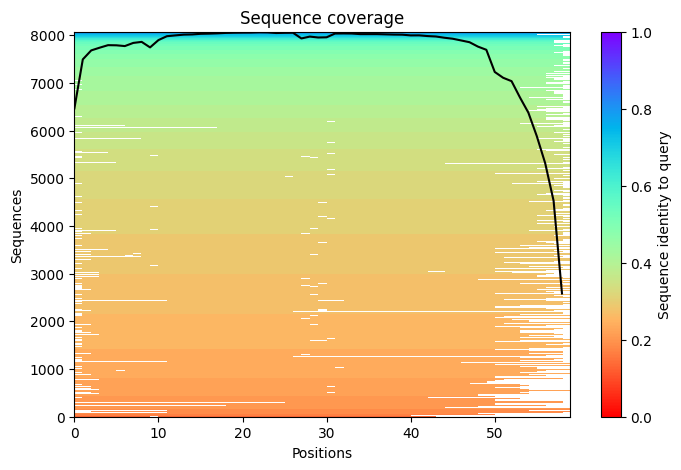

2025-11-27 23:00:36,788 Setting max_seq=512, max_extra_seq=5120
2025-11-27 23:01:16,964 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.5 pTM=0.752
2025-11-27 23:01:40,163 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.4 pTM=0.757 tol=0.266
2025-11-27 23:01:44,654 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.1 pTM=0.754 tol=0.0515
2025-11-27 23:01:49,154 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=95.8 pTM=0.752 tol=0.0509
2025-11-27 23:01:49,155 alphafold2_ptm_model_1_seed_000 took 58.4s (3 recycles)


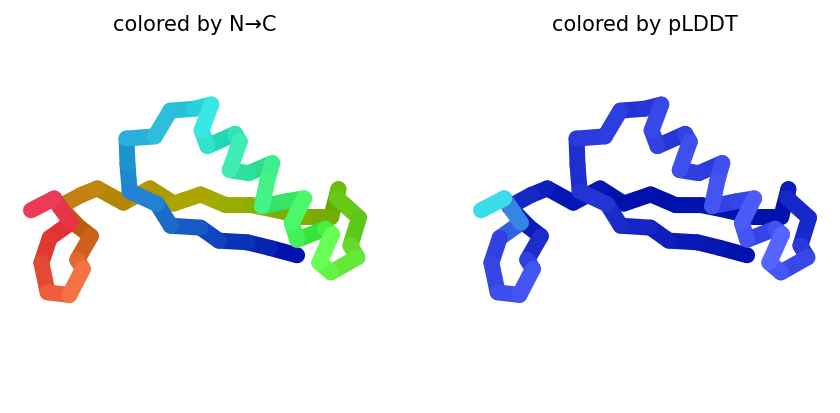

2025-11-27 23:01:53,804 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.9 pTM=0.761
2025-11-27 23:01:58,355 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97 pTM=0.767 tol=0.326
2025-11-27 23:02:02,925 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.9 pTM=0.767 tol=0.162
2025-11-27 23:02:07,509 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.5 pTM=0.762 tol=0.0383
2025-11-27 23:02:07,510 alphafold2_ptm_model_2_seed_000 took 18.3s (3 recycles)


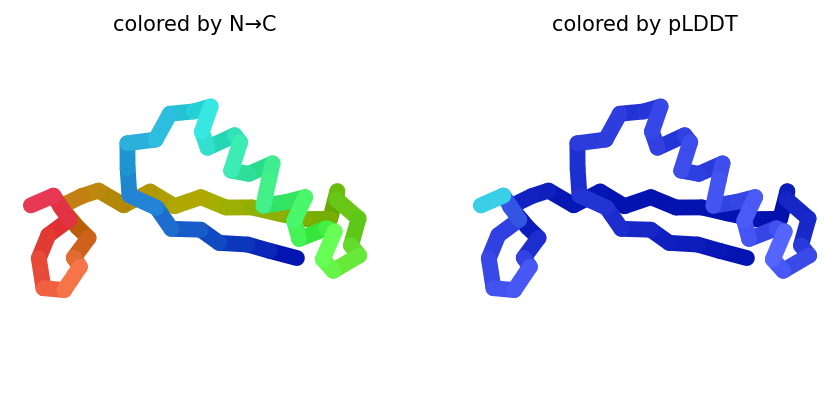

2025-11-27 23:02:12,207 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.776
2025-11-27 23:02:16,843 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.783 tol=0.262
2025-11-27 23:02:21,504 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.783 tol=0.0988
2025-11-27 23:02:26,166 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.783 tol=0.0447
2025-11-27 23:02:26,166 alphafold2_ptm_model_3_seed_000 took 18.6s (3 recycles)


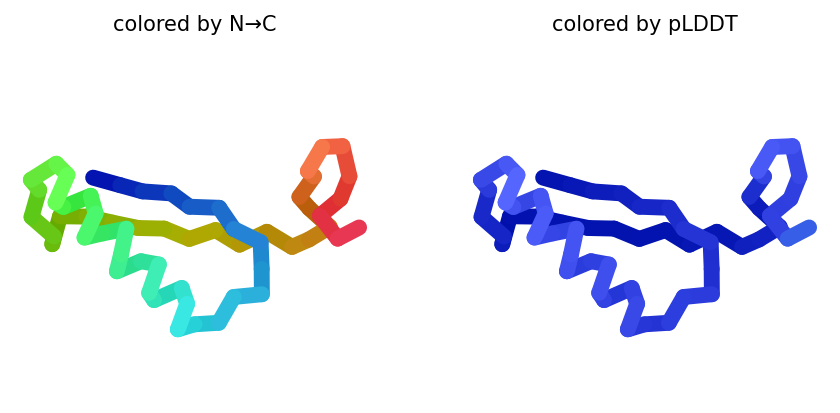

2025-11-27 23:02:30,918 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.1 pTM=0.772
2025-11-27 23:02:35,579 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.1 pTM=0.779 tol=0.215
2025-11-27 23:02:40,250 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=96.9 pTM=0.778 tol=0.0897
2025-11-27 23:02:44,931 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=96.6 pTM=0.775 tol=0.0664
2025-11-27 23:02:44,931 alphafold2_ptm_model_4_seed_000 took 18.7s (3 recycles)


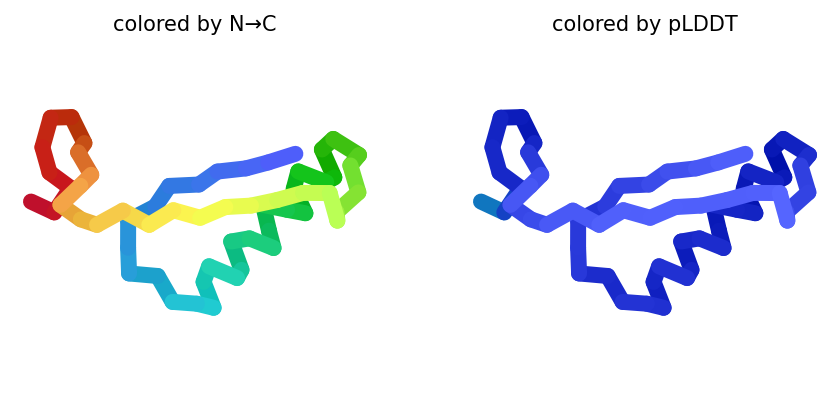

2025-11-27 23:02:49,717 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=96.8 pTM=0.78
2025-11-27 23:02:54,468 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.4 pTM=0.781 tol=0.322
2025-11-27 23:02:59,247 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.4 pTM=0.779 tol=0.157
2025-11-27 23:03:04,043 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.3 pTM=0.778 tol=0.0706
2025-11-27 23:03:04,044 alphafold2_ptm_model_5_seed_000 took 19.0s (3 recycles)


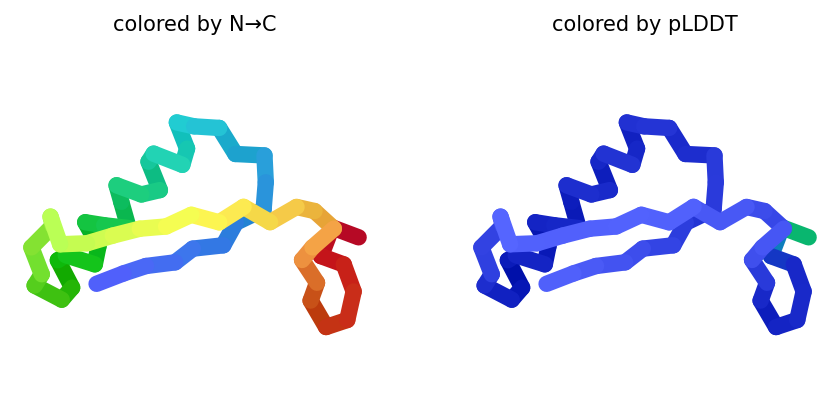

2025-11-27 23:03:04,126 reranking models by 'plddt' metric
2025-11-27 23:03:04,126 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.783
2025-11-27 23:03:04,127 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=96.6 pTM=0.775
2025-11-27 23:03:04,127 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.5 pTM=0.762
2025-11-27 23:03:04,127 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.3 pTM=0.778
2025-11-27 23:03:04,127 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=95.8 pTM=0.752
2025-11-27 23:03:05,101 Done


0

In [8]:
display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1
color = "lDDT" # ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = False

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


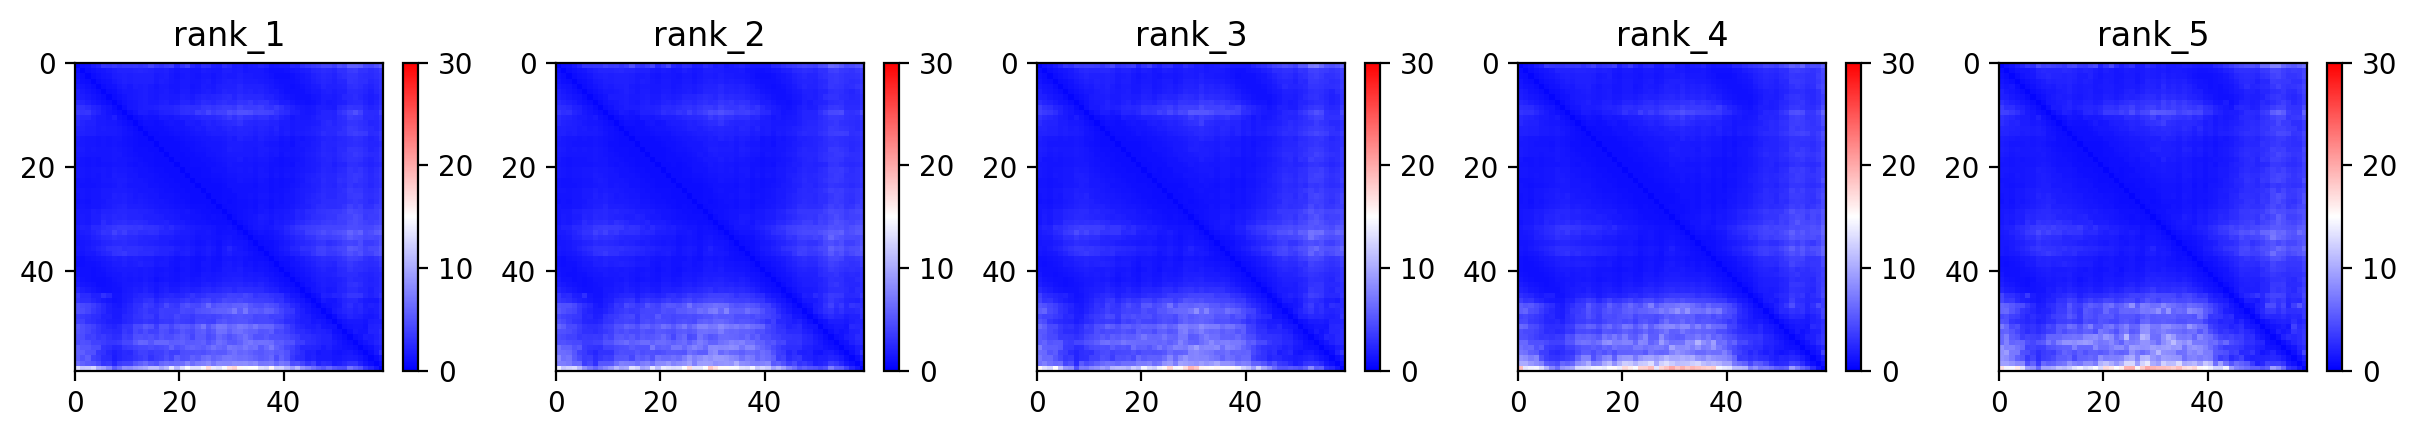
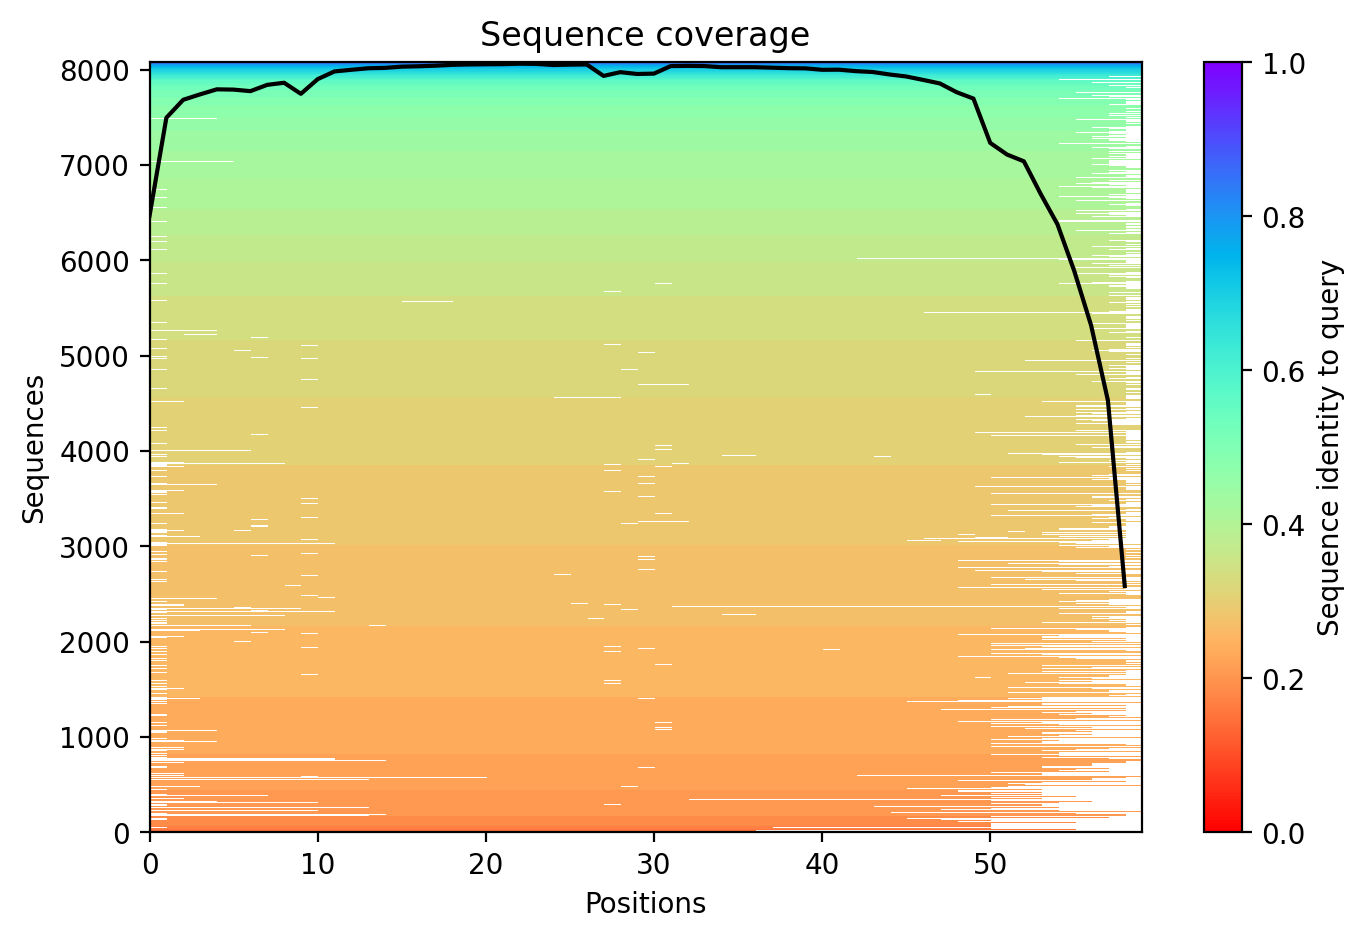
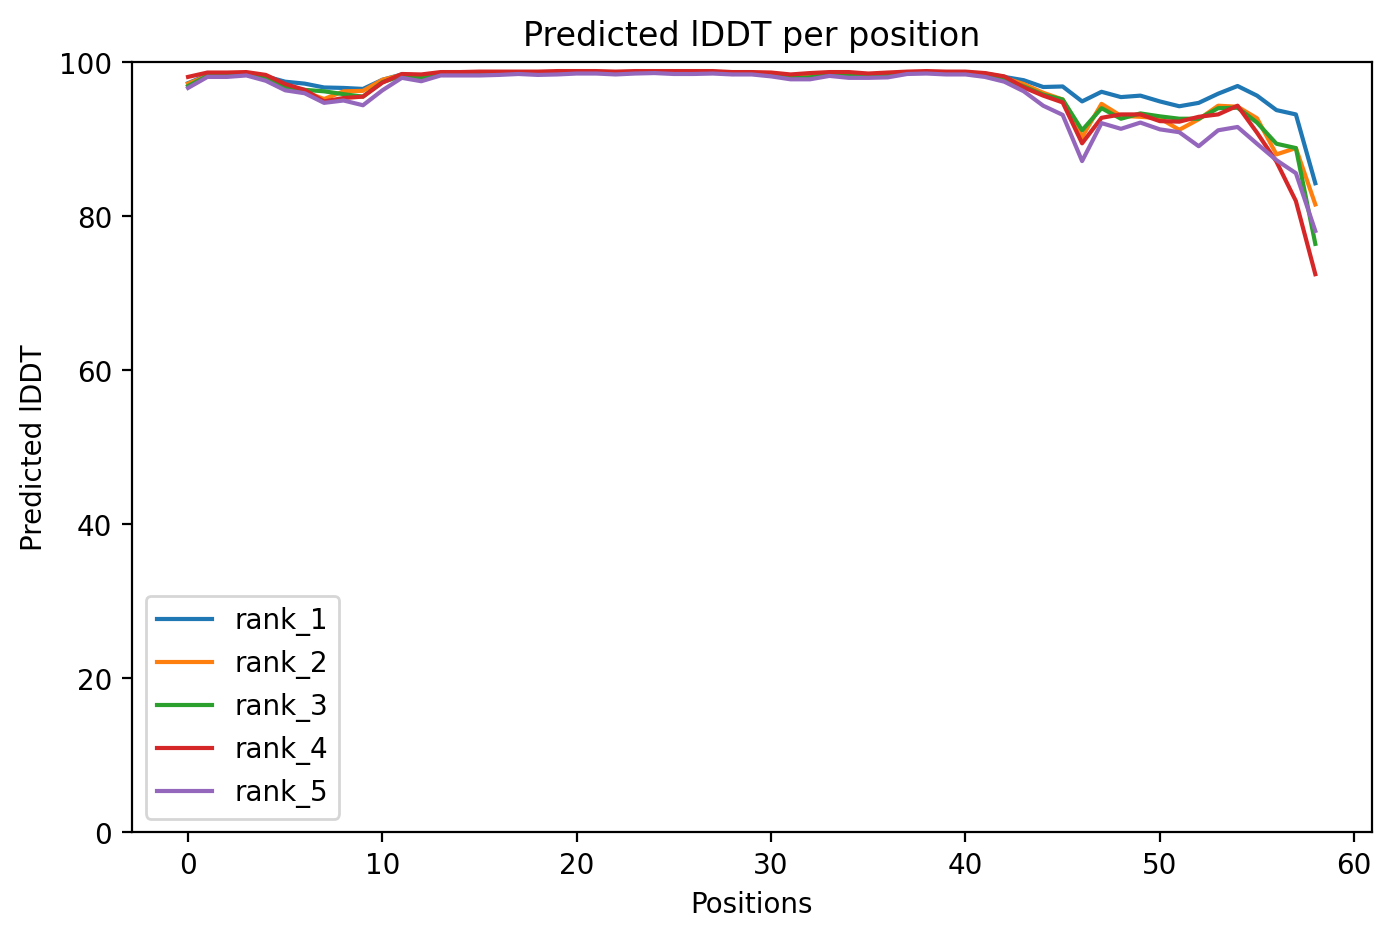

In [10]:
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [30]:
results

{'rank': [['rank_001_alphafold2_ptm_model_3_seed_000',
   'rank_002_alphafold2_ptm_model_4_seed_000',
   'rank_003_alphafold2_ptm_model_2_seed_000',
   'rank_004_alphafold2_ptm_model_5_seed_000',
   'rank_005_alphafold2_ptm_model_1_seed_000']],
 'metric': [[{'mean_plddt': 97.375,
    'ptm': 0.78271484375,
    'print_line': ' pLDDT=97.4 pTM=0.783'},
   {'mean_plddt': 96.625,
    'ptm': 0.77490234375,
    'print_line': ' pLDDT=96.6 pTM=0.775'},
   {'mean_plddt': 96.5,
    'ptm': 0.76220703125,
    'print_line': ' pLDDT=96.5 pTM=0.762'},
   {'mean_plddt': 96.3125,
    'ptm': 0.77783203125,
    'print_line': ' pLDDT=96.3 pTM=0.778'},
   {'mean_plddt': 95.75,
    'ptm': 0.75244140625,
    'print_line': ' pLDDT=95.8 pTM=0.752'}]]}

In [31]:
plddt_scores = [model['mean_plddt'] for model in results['metric'][0]]
print(plddt_scores[0])

97.375


In [32]:
ptm_scores = [model['ptm'] for model in results['metric'][0]]
print(ptm_scores[0])

0.78271484375


In [34]:
# --- Start Gemini Integration for Report Generation ---
import sys
import os
import json

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

# Get the jobname and sequence variables from the notebook's global scope
# Assuming the variables 'jobname' and 'query_sequence' are set from Cell 1
try:
    jobname
except NameError:
    jobname = 'test_a5e17'
try:
    query_sequence
except NameError:
    query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'

try:
    # --- Live Client Initialization ---

    # *** EXCLUSIVE FIX: Using userdata.get('GEMINI') as specified by the user ***
    if 'google.colab' in sys.modules:
        from google.colab import userdata
        GOOGLE_API_KEY = userdata.get('GEMINI')
    else:
        # Fallback for non-Colab environments (though Colab is the primary context)
        GOOGLE_API_KEY = os.environ.get('GEMINI_API_KEY')

    if not GOOGLE_API_KEY:
        # NOTE: The error message now reflects the expected key name
        raise ValueError("API key not found. Please set the secret named 'GEMINI' in Colab.")

    from google import genai
    client = genai.Client(api_key=GOOGLE_API_KEY)

    if not hasattr(client, 'models') or not hasattr(client.models, 'generate_content'):
         raise AttributeError("GenAI Client SDK version is incompatible.")

    GEMINI_MODEL_ID = 'gemini-3-pro-preview'
    print(f"Gemini client successfully configured for model: {GEMINI_MODEL_ID}.")

    # --- Prepare Data for Gemini (Robust Extraction) ---

    top_results = []

    # Assuming the 'results' variable from Cell 8 is available and structured
    if 'rank' in results and results['rank'] and results['rank'][0]:

        ranked_models = results["rank"][0]
        plddt_scores = [model['mean_plddt'] for model in results['metric'][0]]
        ptm_scores = [model['ptm'] for model in results['metric'][0]]

        # Ensure we don't exceed the shortest list's length, or 5
        min_len = min(len(ranked_models), len(plddt_scores), len(ptm_scores), 5)

        for i in range(min_len):
            model_info = {
                "model_rank": i + 1,
                "model_name": ranked_models[i],
                "plddt": plddt_scores[i],
                "ptm": ptm_scores[i]
            }
            top_results.append(model_info)

    if not top_results:
        results_json = "No valid model prediction data could be extracted from the ColabFold results object."
    else:
        results_json = json.dumps(top_results, indent=2)

    # --- Construct and Execute Prompt ---

    prompt = f"""
    You are an expert computational biologist. Your task is to generate a comprehensive, professional report summarizing the AlphaFold2 protein structure prediction results provided below.

    The prediction was run for the following query sequence:
    "{query_sequence}"
    The sequence length is: {len(query_sequence)} residues.

    The model performance is ranked by pLDDT (Predicted Local Distance Difference Test), which measures per-residue confidence (scale 0-100, where >90 is high confidence). pTM (Predicted TM-score) measures overall domain confidence (scale 0-1, where >0.7 is a good prediction).

    --- RAW RESULTS (Ranked by pLDDT) ---
    {results_json}
    ---

    Your report MUST include the following sections:
    1. **Summary of Prediction Quality**: State the best model's rank, pLDDT, and pTM. Interpret these scores in terms of structural confidence (e.g., is it highly accurate, mostly reliable, or low confidence?).
    2. **Analysis of Top Model**: Briefly describe the predicted structure based *only* on the sequence and confidence scores. Speculate on the quality of the local and global fold.
    3. **Interpretation of Confidence Scores**: Explain what the range of pLDDT and pTM scores across the top 5 models suggests about the protein's conformational landscape or the confidence in the ensemble.
    4. **Structural Speculation (Based on Sequence)**: Given the sequence, what type of protein (e.g., enzyme, signaling domain, structural protein) or structural features (e.g., alpha helices, beta sheets, disordered regions) might be expected? (Limit this speculation to the 59-residue input sequence).
    """

    print("\n" + "="*50)
    print("🤖 GENERATING ALPHAFAOLD2 REPORT WITH GEMINI 3 PRO...")
    print("="*50)

    # Call Gemini 3 Pro
    response = client.models.generate_content(
        model=GEMINI_MODEL_ID,
        contents=prompt
    )

    # Print the full generated report
    print(response.text)
    print("="*50)
    print("✅ REPORT GENERATION COMPLETE.")
    print("="*50)

except Exception as setup_error:
    print(f"\n--- Gemini Integration Failed ---")
    print(f"Error: {setup_error}")
    print(f"Skipping LLM report generation and proceeding with file download.")
    print("---------------------------------")


# --- Original Code (Download) ---
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

Gemini client successfully configured for model: gemini-3-pro-preview.

🤖 GENERATING ALPHAFAOLD2 REPORT WITH GEMINI 3 PRO...
2025-11-27 23:44:10,257 AFC is enabled with max remote calls: 10.
2025-11-27 23:44:36,122 HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-3-pro-preview:generateContent "HTTP/1.1 200 OK"
**Computational Biology Report: AlphaFold2 Structure Prediction Analysis**

**Date:** October 26, 2023
**Subject:** Structural Prediction of 59-Residue Query Sequence
**Method:** AlphaFold2 (pTM)

---

### 1. Summary of Prediction Quality

The AlphaFold2 pipeline successfully generated five models for the provided 59-residue query sequence. The structural prediction is assessed as **High Confidence / Very High Accuracy**.

The top-ranked model (**rank_001_alphafold2_ptm_model_3_seed_000**) achieved the following metrics:
*   **pLDDT:** 97.38 (Scale 0–100)
*   **pTM:** 0.783 (Scale 0–1)

**Interpretation:**
A pLDDT score of **97.38** indicates that

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>